In [2]:
import pandas as pd
import os

import jax.numpy as jnp
from jax import random, vmap

!pip3 install numpyro
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

!pip3 install arviz
import arviz as az
import matplotlib.pyplot as plt
if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

     |████████████████████████████████| 264 kB 26.0 MB/s 


/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


## 5.2

In [3]:
d = WaffleDivorce = pd.read_csv("https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/WaffleDivorce.csv", sep=";")
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

## 5.2

In [4]:
d.MedianAgeMarriage.std()

1.243630301388082

## 5.3

In [6]:
def model(A, D=None):
    a = numpyro.sample('a', dist.Normal(0, 0.2))
    bA = numpyro.sample('bA', dist.Normal(0, 0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bA * A)
    numpyro.sample('D', dist.Normal(mu, sigma))

m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), Trace_ELBO(), A=d.A.values, D=d.D.values)
p5_1 = svi.run(random.PRNGKey(0), 1000).params

100%|██████████| 1000/1000 [00:01<00:00, 741.89it/s, init loss: 1840.6746, avg. loss [951-1000]: 308.8410]


## 5.4

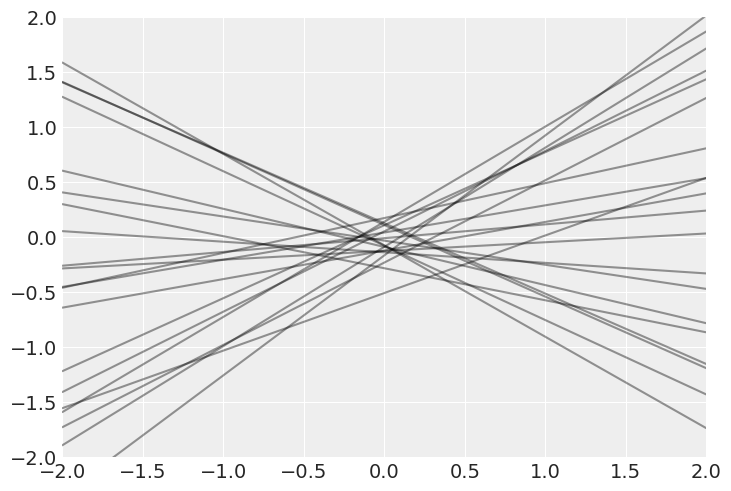

In [8]:
predictive = Predictive(m5_1.model, num_samples=1000)
prior_pred = predictive(random.PRNGKey(10), A=jnp.array([-2, 2]))
mu = prior_pred["mu"]
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)